In [7]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import nltk
%matplotlib inline

import os

import matplotlib
font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size'   : 22}
matplotlib.rc('font', **font)

In [25]:
import pickle
from langdetect import detect

## Download and Preprocessing

In [12]:
biz = pd.read_csv('toronto/toronto_biz.csv')
users = pd.read_csv('toronto/toronto_users.csv')
reviews = pd.read_csv('toronto/toronto_reviews.csv')
elite_users = user[~user.elite.str.contains('None')]

In [9]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

In [10]:
#Removes non-english reviews (~900)
non_english = []
for rev in reviews.iloc[:].itertuples():
    try:
        if not detect(rev.text) == 'en':
            non_english.append(rev)
    except:
        continue

#copy original reviews and delete the non english ones
rev_ids = [i.review_id for i in non_english]
reviews_all = reviews.copy()

for i,rev_id in enumerate(rev_ids):
    reviews = reviews[~(reviews['review_id']==rev_id)]

In [13]:
#Dictionary of users who have attained lite status and those years of eliteness
elite_dict = {u.user_id:u.elite.split(',') for u in users.itertuples() if not u.elite == 'None'}

## Text Analysis

In [15]:
import nltk, re, pprint
from nltk import word_tokenize
from collections import Counter

from nltk.stem.wordnet import WordNetLemmatizer

In [22]:
import csv
path = '../labMT.txt'
reader = csv.reader(open(path), delimiter='\t')
lines = [l for l in reader]
header = lines[3]
labMT = lines[4:] 

In [23]:
#Words already processed in order to reduce time complexity
processed_english = {} #key: reduced word, sentiment
nonenglish_words = []

In [24]:
#Elite and regular 
elite_english = {i:Counter() for i in range(1,6)}
elite_ne = {i:Counter() for i in range(1,6)}

reg_english= {i:Counter() for i in range(1,6)}
reg_ne= {i:Counter() for i in range(1,6)}

In [25]:
elite_sent = {i:[] for i in range(1,6)}
reg_sent = {i:[] for i in range(1,6)}

In [26]:
elite_english_len = {i:[] for i in range(1,6)}
elite_ne_len = {i:[] for i in range(1,6)}

reg_english_len = {i:[] for i in range(1,6)}
reg_ne_len = {i:[] for i in range(1,6)}

In [27]:
for rev in reviews.iloc[10000:100000].itertuples(): #30000:100000
    #Preprocessing
    txt = word_tokenize(rev.text)
    txt = [t.lower() for t in txt if re.search('^[a-zA-Z]+$',t)] #Removes numbers/punctuation
    #txt = [nltk.PorterStemmer().stem(t) for t in txt] #Stems the words
    txt = [t for t in txt if t not in nltk.corpus.stopwords.words('english')] #remove stopwords
    
    sentiment = []
    english = []
    non_english = []
    for t in txt:
        is_english = True
        new_t = None
        #Find english form
        if t in processed_english.keys():
            new_t,sent = processed_english[t]
            english.append(new_t),sentiment.append(sent)
            continue
        elif t in nonenglish_words:
            non_english.append(t)
            continue
        elif t in english_vocab:
            new_t = t 
        elif nltk.SnowballStemmer('english').stem(t) in english_vocab:
            new_t = nltk.SnowballStemmer('english').stem(t)
        elif WordNetLemmatizer().lemmatize(t,'v') in english_vocab:
            new_t = WordNetLemmatizer().lemmatize(t,'v')
        elif WordNetLemmatizer().lemmatize(t,'a') in english_vocab:
            new_t = WordNetLemmatizer().lemmatize(t,'a')
        else:
            is_english = False
            
        #Indentify sentiment and update
        if is_english:
            english.append(t)
            processed_english[t] = (new_t, 0)
            for item in labMT: 
                if (t == item[0]): 
                    sent = float(item[2])
                    processed_english[t] = (new_t, sent)
                    sentiment.append(sent)
                    break
        else:
            nonenglish_words.append(t)
            non_english.append(t)
    
    
    if rev.user_id in elite_dict.keys() and rev.date.split('-')[0] in elite_dict[rev.user_id]:
        elite_english[rev.stars].update(english)
        elite_ne[rev.stars].update(non_english)
        
        elite_english_len[rev.stars].append(len(english))
        elite_ne_len[rev.stars].append(len(non_english))
        
        elite_sent[rev.stars].append(sentiment)
    else:
        reg_english[rev.stars].update(english)
        reg_ne[rev.stars].update(non_english)
        
        reg_english_len[rev.stars].append(len(english))
        reg_ne_len[rev.stars].append(len(non_english))
        
        reg_sent[rev.stars].append(sentiment)

KeyboardInterrupt: 

In [ ]:
check = False
if check:
    with open('./Toronto_data/elite_ne.pickle', 'wb') as handle:
        pickle.dump(elite_ne, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/elite_english.pickle', 'wb') as handle:
        pickle.dump(elite_english, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/elite_sent.pickle', 'wb') as handle:
        pickle.dump(elite_sent, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('./Toronto_data/reg_ne.pickle', 'wb') as handle:
        pickle.dump(reg_ne, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/reg_english.pickle', 'wb') as handle:
        pickle.dump(reg_english, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('./Toronto_data/reg_sent.pickle', 'wb') as handle:
        pickle.dump(reg_sent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
check = False
if check:
    with open('./Toronto_data/elite_reviews.pickle', 'rb') as handle:
        elite_revs = pickle.load(handle)

    with open('./Toronto_data/regular_reviews.pickle', 'rb') as handle:
        reg_revs = pickle.load(handle)

In [ ]:
def tf_idf(docs):
    N = len(docs)
    #IDF
    idf = {}
    for doc in docs:
        for term in doc.keys():
            if term not in idf.keys():
                idf[term] = 1
            else:
                idf[term] += 1
    
    #TF-IDF
    for doc in docs:
        for term in doc.keys():
            #TF * IDF
            doc[term] = doc[term] * np.log(N / (idf[term]))
    
    return docs

In [ ]:
def sum_counter(counters):
    cntr = Counter()
    for c in counters:
        cntr = cntr + c
    return cntr

In [ ]:
tfidfs = tf_idf([sum_counter(elite_english.values()),sum_counter(reg_english.values())])

In [993]:
names = ['Elites','Regular']

In [999]:
tfidfs = tf_idf([i for i in elite_english.values()] + [i for i in reg_english.values()])

In [1000]:
names = ['Elite 1 Star','Elite 2 Star','Elite 3 Star','Elite 4 Star','Elite 5 Star',
         'Regular 1 Star','Regular 2 Star','Regular 3 Star','Regular 4 Star','Regular 5 Star',]

In [1001]:
wordCloud = []
for tfidf in tfidfs:
    wordCloud.append(' '.join([' '.join([word]*abs(int(val))) for word,val in tfidf.items()]))

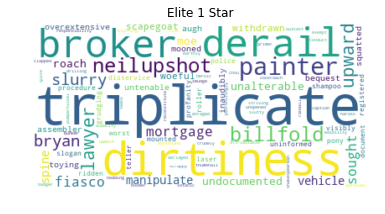

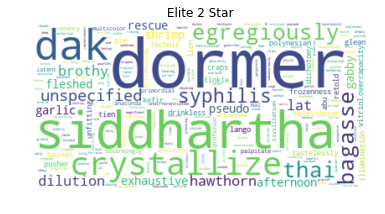

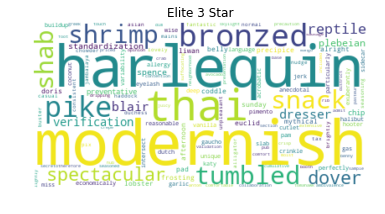

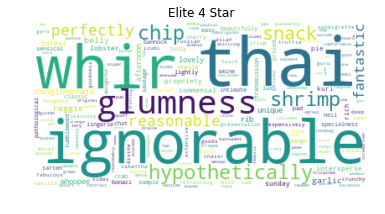

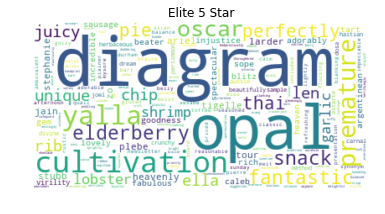

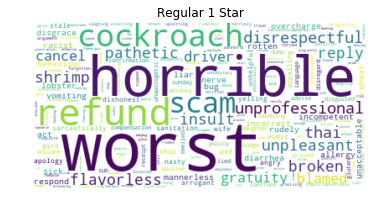

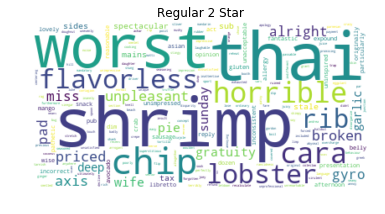

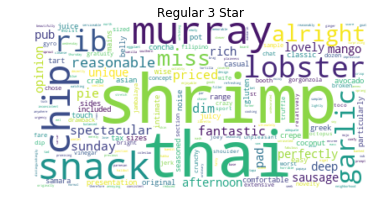

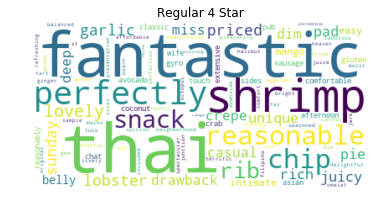

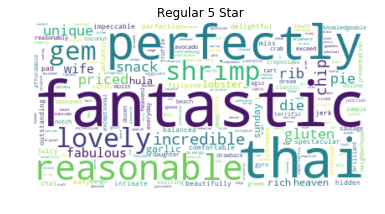

In [1002]:
from wordcloud import WordCloud

for cloud,name in zip(wordCloud,names):
    # Generate a word cloud image
    # lower max_font_size
    wc = WordCloud(max_font_size=80,collocations=False,background_color='white').generate(cloud)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name)
    plt.show()

# Sentiment Analysis

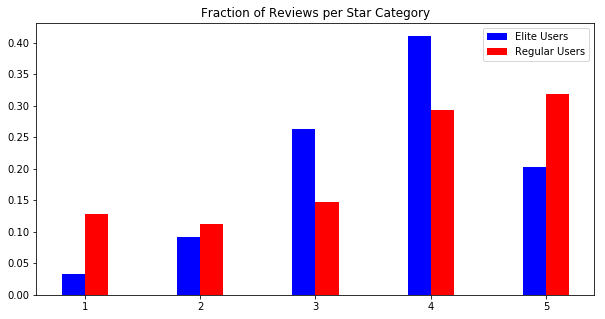

In [1006]:
#fig,axes = plt.subplots(5, 2, sharex=True, sharey=True)
plt.figure(figsize=(10,5))
x = np.arange(1,6)
y_elite = np.array([len(elite_sent[i]) for i in x])
y_elite = y_elite / sum(y_elite)
y_reg = np.array([len(reg_sent[i]) for i in x])
y_reg = y_reg / sum(y_reg)

plt.bar(x-0.1, y_elite,width=0.2,color='b',align='center',label='Elite Users')
plt.bar(x+0.1, y_reg,width=0.2,color='r',align='center',label='Regular Users')

plt.legend()
plt.title('Fraction of Reviews per Star Category')
plt.xticks(x)
plt.show()

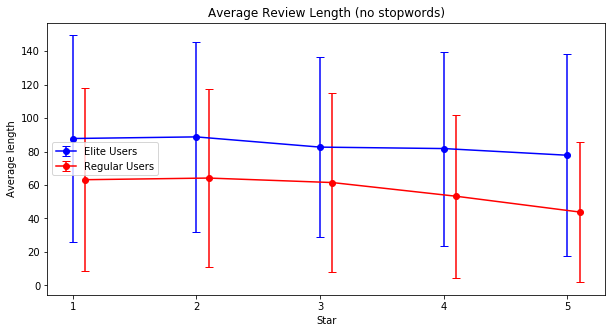

In [1007]:
plt.figure(figsize=(10,5))
plt.title('Average Review Length (no stopwords)')
plt.xlabel('Star')
plt.ylabel('Average length')
x = np.arange(1,6)
plt.errorbar(x,[np.mean([i1+i2 for i1,i2 in zip(elite_english_len[i],elite_ne_len[i])]) for i in x],
             yerr=[np.std([i1+i2 for i1,i2 in zip(elite_english_len[i],elite_ne_len[i])]) for i in x],
             linestyle='-', marker='o',capsize=4,color='blue',label='Elite Users')
plt.errorbar(x+0.1,[np.mean([i1+i2 for i1,i2 in zip(reg_english_len[i],reg_ne_len[i])]) for i in x],
             yerr=[np.std([i1+i2 for i1,i2 in zip(reg_english_len[i],reg_ne_len[i])]) for i in x],
             linestyle='-', marker='o',capsize=4,color='red',label='Regular Users')
plt.legend()
plt.show()

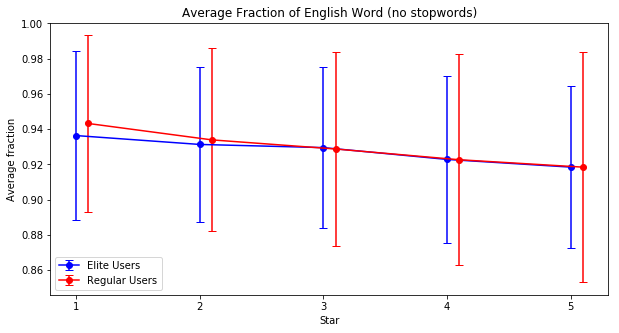

In [1009]:
plt.figure(figsize=(10,5))
plt.title('Average Fraction of English Word (no stopwords)')
plt.xlabel('Star')
plt.ylabel('Average fraction')
x = np.arange(1,6)
plt.errorbar(x,[np.mean([i1/(i1+i2) for i1,i2 in zip(elite_english_len[i],elite_ne_len[i]) if i1+i2>0]) for i in x],
             yerr=[np.std([i1/(i1+i2) for i1,i2 in zip(elite_english_len[i],elite_ne_len[i]) if i1+i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='blue',label='Elite Users')
plt.errorbar(x+0.1,[np.mean([i1/(i1+i2) for i1,i2 in zip(reg_english_len[i],reg_ne_len[i]) if i1+i2>0]) for i in x],
             yerr=[np.std([i1/(i1+i2) for i1,i2 in zip(reg_english_len[i],reg_ne_len[i]) if i1+i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='red',label='Regular Users')
plt.legend()
plt.show()

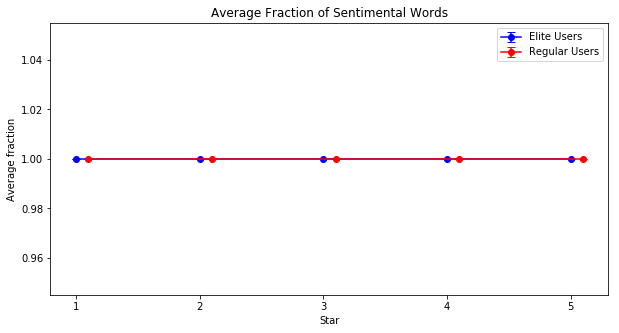

In [1012]:
plt.figure(figsize=(10,5))
plt.title('Average Fraction of Sentimental Words')
plt.xlabel('Star')
plt.ylabel('Average fraction')
x = np.arange(1,6)
plt.errorbar(x,[np.mean([len(i1)/i2 for i1,i2 in zip(elite_sent[i],elite_english_len[i]) if i2>0]) for i in x],
             yerr=[np.std([len(i1)/i2 for i1,i2 in zip(elite_sent[i],elite_english_len[i]) if i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='blue',label='Elite Users')
plt.errorbar(x+0.1,[np.mean([len(i1)/i2 for i1,i2 in zip(reg_sent[i],reg_english_len[i]) if i2>0]) for i in x],
             yerr=[np.std([len(i1)/i2 for i1,i2 in zip(reg_sent[i],reg_english_len[i]) if i2>0]) for i in x],
             linestyle='-', marker='o',capsize=4,color='red',label='Regular Users')
plt.legend()
plt.show()

In [1036]:
labMT_mean = np.mean([float(i[2]) for i in labMT])
labMT_std = np.std([float(i[2]) for i in labMT])
elite_sent_extrema = {i:[] for i in range(1,6)}
reg_sent_extrema = {i:[] for i in range(1,6)}

In [1037]:
for i in range(1,6):
    for cnt,sents in zip(elite_english_len[i], elite_sent[i]):
        if len(sents)==0: continue
        l = 0; m = 0;h = 0
        for sent in sents:
            if sent < labMT_mean - 1*labMT_std:
                l += 1
            elif sent > labMT_mean + 1*labMT_std:
                h += 1
            else:
                m += 1
        total = l+m+h
        elite_sent_extrema[i].append((l/total,m/total,h/total))
for i in range(1,6):
    for cnt,sents in zip(reg_english_len[i], reg_sent[i]):
        if len(sents)==0: continue
        l=0; m = 0; h = 0
        for sent in sents:
            if sent < labMT_mean - 1*labMT_std:
                l += 1
            elif sent > labMT_mean + 1*labMT_std:
                h += 1
            else:
                m += 1
        total = l+m+h
        reg_sent_extrema[i].append((l/total,m/total,h/total))

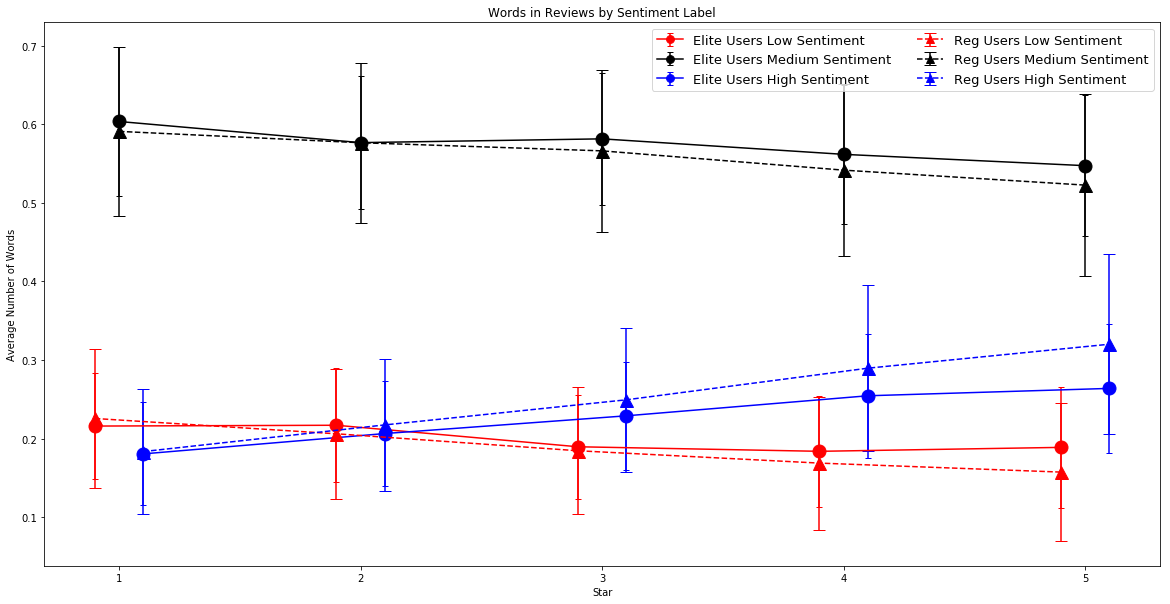

In [1038]:
plt.figure(figsize=(20,10))
plt.title('Words in Reviews by Sentiment Label')
plt.xlabel('Star')
plt.ylabel('Average Number of Words')
x = np.arange(1,6)

plt.errorbar(x-0.1,[np.mean([rev[0] for rev in elite_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[0] for rev in elite_sent_extrema[i]]) for i in x],
             linestyle='-', marker='o',markersize=13,capsize=3,color='red',label='Elite Users Low Sentiment')
plt.errorbar(x,[np.mean([rev[1] for rev in elite_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[1] for rev in elite_sent_extrema[i]]) for i in x],
             linestyle='-', marker='o',markersize=13,capsize=3,color='black',label='Elite Users Medium Sentiment')
plt.errorbar(x+0.1,[np.mean([rev[2] for rev in elite_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[2] for rev in elite_sent_extrema[i]]) for i in x],
             linestyle='-', marker='o',markersize=13,capsize=3,color='blue',label='Elite Users High Sentiment')

plt.errorbar(x-0.1,[np.mean([rev[0] for rev in reg_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[0] for rev in reg_sent_extrema[i]]) for i in x],
             linestyle='--', marker='^',markersize=13,capsize=6,color='red',label='Reg Users Low Sentiment')
plt.errorbar(x,[np.mean([rev[1] for rev in reg_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[1] for rev in reg_sent_extrema[i]]) for i in x],
             linestyle='--', marker='^',markersize=13,capsize=6,color='black',label='Reg Users Medium Sentiment')
plt.errorbar(x+0.1,[np.mean([rev[2] for rev in reg_sent_extrema[i]]) for i in x],
             yerr=[np.std([rev[2] for rev in reg_sent_extrema[i]]) for i in x],
             linestyle='--', marker='^',markersize=13,capsize=6,color='blue',label='Reg Users High Sentiment')

plt.legend(loc='upper right',ncol = 2,fontsize=13,markerscale=0.6)
plt.show()

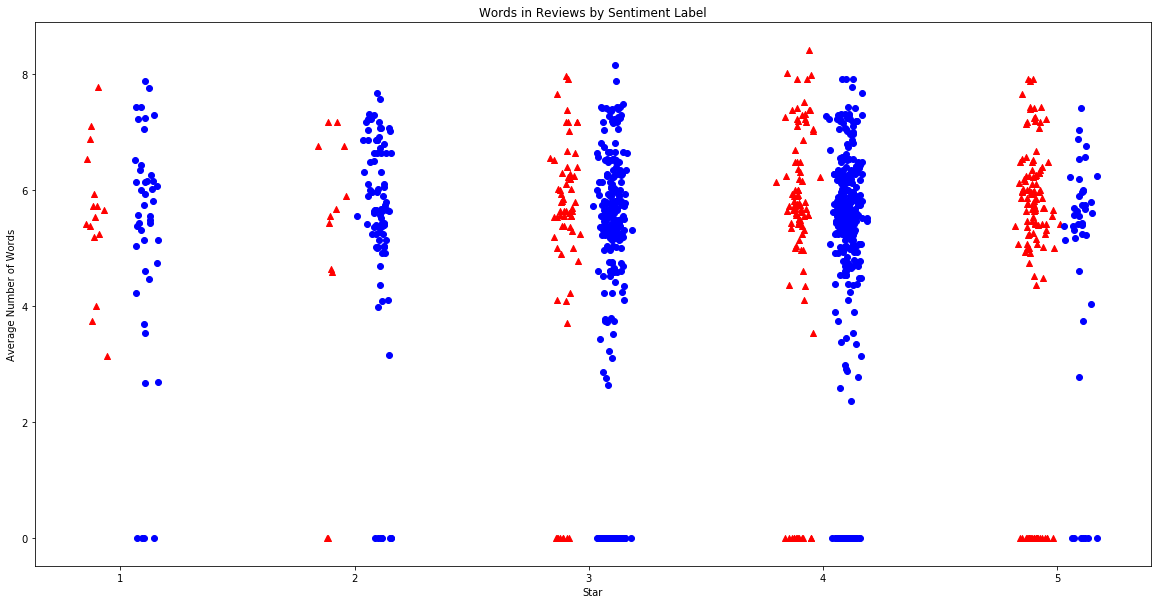

In [1067]:
plt.figure(figsize=(20,10))
plt.title('Words in Reviews by Sentiment Label')
plt.xlabel('Star')
plt.ylabel('Average Number of Words')
x = np.arange(1,6)

for i in x:
    plt.scatter(np.random.normal(i-0.1,0.03,len(elite_sent[i][0])),elite_sent[i][0], marker='^',color='red',label='Elite Users Low Sentiment')
    plt.scatter(np.random.normal(i+0.1,0.03,len(reg_sent[i][0])),reg_sent[i][0], marker='o',color='blue',label='Reg Users Low Sentiment')

plt.show()